In [2]:
import cv2 as cv
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 20

In [3]:
filenames = []
total_images = os.walk('./NemaLife Images_Converted/')
print("Loading Files...")
for (a, b, files) in total_images:
    for f in files:
        filenames.append(f)
print(f"Files: {len(filenames)}")


Loading Files...
Files: 151


In [3]:
# Contrast Stretch
mean_vect = []

for f in filenames:
    img = cv.imread(f'./NemaLife Images_Converted/{f}', 0)
    mean_value = np.mean(img)
    mean_vect.append(mean_value)
mean_brightness = np.mean(mean_vect)
print(f"Absolute Mean: {mean_brightness}")

Absolute Mean: 163.03451732137376


In [6]:
print("Contrast Stretching...")
try:
    os.mkdir("ContrastStretch")
except:
    print("Directory already exists")
try:
    for f in filenames:
        img = cv.imread(f'./NemaLife Images_Converted/{f}', 0)
        actual_mean = np.mean(img)
        diff = abs(mean_brightness - actual_mean)
        if mean_brightness > actual_mean:
            img = abs(img + diff)
        else:
            img = abs(img - diff)
        cv.imwrite(f"./ContrastStretch/{f}", img)
    print("\nContrast Stretching Completed.")
except:
    print("Contrast Stretching Failed.")

Contrast Stretching...
Directory already exists


In [3]:
def pad_images_to_same_size(images):
    '''
    Recursively pads the output image to the max value: 40
    '''
    h, w = images.shape[:2]
    width_max = max(40, w)
    height_max = max(40, h)
    if width_max > 40:
        dim = (40, round(h * 40 / w))
        images = cv.resize(images, dim, interpolation=cv.INTER_AREA)
    if height_max > 40:
        dim = (round(40 * w / h), 40)
        images = cv.resize(images, dim, interpolation=cv.INTER_AREA)

    h, w = images.shape[:2]
    width_max = max(40, w)
    height_max = max(40, h)

    diff_vert = height_max - h
    pad_top = diff_vert // 2
    pad_bottom = pad_top
    diff_hori = width_max - w
    pad_left = diff_hori // 2
    pad_right = pad_left
    img_padded = cv.copyMakeBorder(
        images, pad_top, pad_bottom, pad_left, pad_right, cv.BORDER_CONSTANT, value=0)

    check_h, check_w = img_padded.shape

    if (check_h <= 40 and check_w <= 40):
        if check_h != 40:
            img_padded = cv.copyMakeBorder(
                img_padded, 1, 0, 0, 0, cv.BORDER_CONSTANT, value=0)
        if check_w != 40:
            img_padded = cv.copyMakeBorder(
                img_padded, 0, 0, 1, 0, cv.BORDER_CONSTANT, value=0)
        return img_padded
    else:
        return pad_images_to_same_size(img_padded)

In [19]:
ite = 0
worm_og = []
no_worm_og = []
num = 0
path_noworm = os.path.join("Output/NoWorm/")
path_worm = os.path.join("Output/Worm/")
def createDir(path):
    '''
    Creates the specified directory, if it doesn't exist.
    '''
    try:
        os.makedirs(path, exist_ok=True)
        print(f'Created directory: {path}')
    except:
        print("Path creation Failed.")

createDir(path_noworm)
createDir(path_worm)

In [20]:
# MAIN LOOP
for images in filenames:
    '''
    Fetches all images from the contrast equalized images.
    Utilizes adaptive thresholding to form bounding boxes around worms.
    Crops, pads to size and exports to specific folder.
    '''
    num += 1
    img = cv.imread(f'./ContrastStretch/{images}', 0)
    img_og = img  # original copy for cropping contours
    path_noworm = os.path.join(f'Output/NoWorm/')
    path_worm = os.path.join(f'Output/Worm/')
    createDir(path_noworm)
    createDir(path_worm)
    # adptiveThreshold of Contrast Stretched images
    th1 = cv.adaptiveThreshold(
        img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 99, -35, None)
    # uncomment to show threshold image    
    # cv.imshow("img", th1); cv.waitKey(0); cv.destroyAllWindows()
    contours, hierarchy = cv.findContours(
        th1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # cropping the contours
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        if w * h < 300 or w * h > 4900:  # disregards boxes
            continue

        cropped = img_og[y:y + h, x:x + w]
        cropped_check = th1[y:y + h, x:x + w]
        # check which class the boxed image go to
        # pad/resize the cropped image
        # save to respective directory
        if np.mean(cropped_check) < 85 and np.mean(cropped_check) > 40:
            cropped = pad_images_to_same_size(cropped)
            cv.imwrite(f'{path_worm}{ite}.jpg', cropped)
            _, cropped = cv.threshold(cropped, 200, 255, cv.THRESH_BINARY)
            worm_og.append(np.mean(cropped))
        elif np.mean(cropped_check) < 20 or np.mean(cropped_check) > 100:
            cropped = pad_images_to_same_size(cropped)
            cv.imwrite(f'{path_noworm}{ite}.jpg', cropped)
            _, cropped = cv.threshold(cropped, 200, 255, cv.THRESH_BINARY)
            no_worm_og.append(np.mean(cropped))
        ite += 1

    # loop to show boxed images
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        if w * h < 400 or w * h > 4900:
            continue
        boxed_img = cv.rectangle(img_og, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # cv.imshow("img", boxed_img); cv.waitKey(0); cv.destroyAllWindows()
    # uncomment to show boxed image

            

        


In [4]:
def horizontalFlip(image):
    return np.fliplr(image)
    
def verticalFlip(image):
    return np.flipud(image)

def rotateClock(image):
    return cv.rotate(image, cv.ROTATE_90_CLOCKWISE)

def rotateAntiClock(image):
    return cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)

augmentationFunctions = {
    '0': horizontalFlip,
    '1': verticalFlip,
    '2': rotateClock,
    '3': rotateAntiClock,
}

def augmentation(path,image,saveName):
    image = cv.imread(path+image, 0)
    randomChoice = random.randint(0,3)
    output = augmentationFunctions[str(randomChoice)](image)   
    cv.imwrite(f'{path}/{saveName}.jpg', output)

In [15]:
imgFiles = []
total_images = os.walk('./Output/NoWorm/')
print("Loading Files...")
for (a, b, files) in total_images:
    for f in files:
        imgFiles.append(f)


Loading Files...


In [16]:
len(imgFiles)

1306

In [17]:
totalImages = len(imgFiles)
saveName = 0
while totalImages <10000:
    image = random.choice(imgFiles)
    augmentation('./Output/NoWorm/', image, str(totalImages)+'augmented')
    totalImages+=1

In [7]:
worm = []
for img in os.listdir('./Output Last Update/Worm/'):
    image = cv.imread(f'./Output Last Update/Worm/{img}',0)
    worm.append(np.mean(image))
noworm = []
for img in os.listdir('./Output Last Update/NoWorm/'):
    image = cv.imread(f'./Output Last Update/NoWorm/{img}',0)
    noworm.append(np.mean(image))

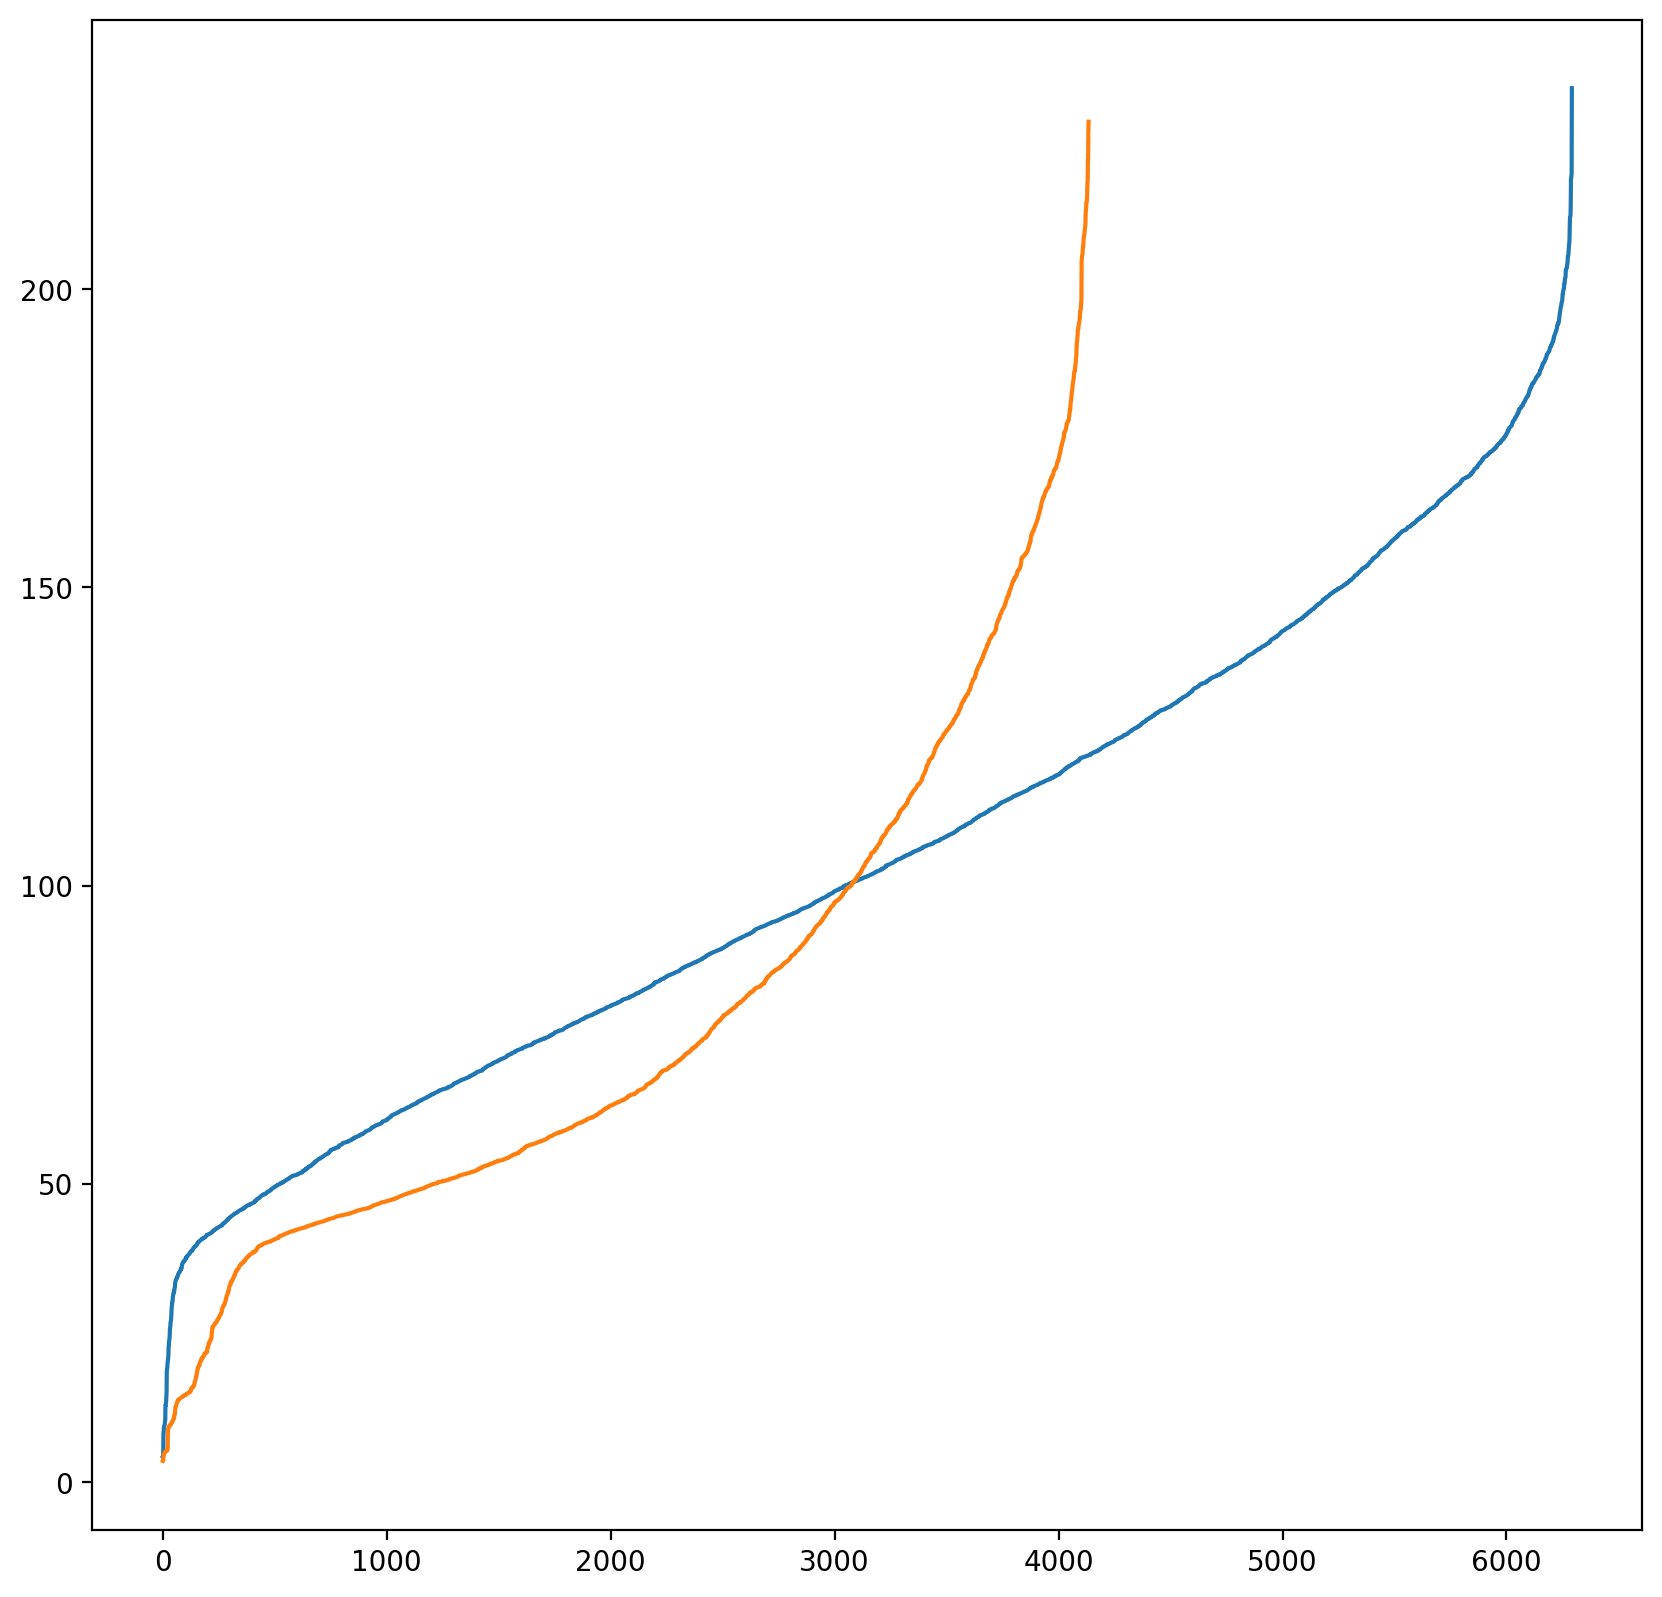

In [8]:
plt.figure(figsize=(10,10), dpi= 100)
plt.plot(sorted(worm))
plt.plot(sorted(noworm))

In [11]:
worm = []
for img in os.listdir('./ZZZ Copy/Worm/'):
    image = cv.imread(f'./ZZZ Copy/Worm/{img}',0)
    worm.append(np.mean(image))
noworm = []
for img in os.listdir('./ZZZ Copy/NoWorm/'):
    image = cv.imread(f'./ZZZ Copy/NoWorm/{img}',0)
    noworm.append(np.mean(image))

In [1]:
plt.figure(figsize=(10,10), dpi= 100)
plt.plot(sorted(worm))
plt.plot(sorted(noworm))

NameError: name 'plt' is not defined